In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:

!pip -qqq install pydub
!pip -qqq install tensorboard
!pip -qqq install visualkeras
!pip -qqq install --upgrade keras
!pip -qqq install --upgrade keras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
import os
import math
import numpy as np
import librosa
import json
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import visualkeras
from keras.utils import plot_model
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.svm import SVC
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Audio
from scipy.io import wavfile
import scipy
import soundfile as sf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from pydub import AudioSegment
import random

import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from pydub import AudioSegment
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
#sound_dir = os.path.join(base_dir, 'Sound_1_Sec_5_Files')

image_dir = os.path.join(base_dir,  'STFT_Images_1_Sec')
train_dir = os.path.join(image_dir, 'Train/Sounds')
test_dir = os.path.join(image_dir, 'Test/Sounds')

# Check if the train_dir exists
if os.path.exists(image_dir):
  if os.path.exists(train_dir):
    if os.path.exists(test_dir):
      print(f"train_dir exists: {image_dir}")
  else:
    print(f"train_dir does not exist: {train_dir}")

#train_dir = r"/content/drive/MyDrive/ASE_Dataset_Folder/Images_1_Sec/Train"
#test_dir = r"/content/drive/MyDrive/ASE_Dataset_Folder/Images_1_Sec/Test"



# List files in the train directory
train_files = os.listdir(train_dir)
print(f"Files in train directory: {train_files}")  # Print first all files
print(f"Total of files in Train Directory are :", len(train_files))

# List files in the test directory
test_files = os.listdir(test_dir)
print(f"Files in test directory: {test_files}")  # Print first all files
print(f"Total of files in Test Directory are :", len(test_files))



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
import os
import tensorflow as tf

# Configuration
num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)
channels = 3
batch_size = 32
epochs = 180

# Image Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Check data
if len(train_generator) == 0:
    raise ValueError(f"Train generator is empty. Check the directory: {train_dir}")
if len(test_generator) == 0:
    raise ValueError(f"Test generator is empty. Check the directory: {test_dir}")

# RNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((width, height * channels), input_shape=(height, width, channels)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),  # Existing LSTM layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training Loop
metrics_data = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_generator.reset()

    history = cnn_model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        verbose=1
    )

    accuracy = history.history['accuracy'][0]
    val_accuracy = history.history['val_accuracy'][0]

    print(f"Train Accuracy: {accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
    metrics_data.append([epoch + 1, accuracy, val_accuracy])

# Save Model
model.save('/content/drive/MyDrive/RNN/STFT_RNN/al-emadi_rnn_stft_standardized_unknown_1_test.keras')


In [ ]:
model.save('/content/drive/MyDrive/RNN/STFT_RNN/al-emadi_rnn_stft_standardized_unknown_1_test.keras')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
csv_path = '/content/drive/MyDrive/RNN/STFT_RNN/metrics.csv'
df = pd.read_csv(csv_path)

# --- Accuracy Plot ---
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy')
plt.plot(df['Epoch'], df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Loss Plot (optional) ---
if 'Train Loss' in df.columns and 'Validation Loss' in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
    plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Loss values not found in CSV. Skipping loss plot.")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Configuration ---
num_classes = 12
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1
channels = 3
batch_size = 32

audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)

# --- Load model ---
model = tf.keras.models.load_model('/content/drive/MyDrive/RNN/STFT_RNN/al-emadi_cnn_stft_standardized_unknown_1_test.keras')

# --- Prepare test data ---
test_dir = '/content/drive/MyDrive/ASE_Dataset_Folder/STFT_Images_1_Sec/Test/Sounds'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# --- Evaluate Model ---
loss, accuracy = model.evaluate(test_generator)
print("\n✅ Model Evaluation:")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Predictions ---
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\n📊 Confusion Matrix:")
print(conf_matrix)

# --- Per-Class Accuracy ---
class_accuracy = {}
for i, class_label in enumerate(class_labels):
    correct_indices = np.where(true_classes == i)[0]
    correct_predictions = np.sum(predicted_classes[correct_indices] == i)
    total_samples = len(correct_indices)
    class_accuracy[class_label] = correct_predictions / total_samples if total_samples > 0 else 0.0

print("\n🎯 Accuracy for Each Class:")
for label in class_labels:
    print(f"{label}: {class_accuracy[label]:.4f}")

# --- Classification Report ---
print("\n📄 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# -----------------------------
# 📊 VISUALIZATION SECTION
# -----------------------------

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 2. Per-Class Accuracy Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**#NEW VERSIONS**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix




In [6]:
# -----------------------------
# 📁 CONFIGURATION
# -----------------------------
base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
image_dir = os.path.join(base_dir, 'STFT_Images_1_Sec')
train_dir = os.path.join(image_dir, 'Train/Sounds')
test_dir = os.path.join(image_dir, 'Test/Sounds')

num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1  # seconds
channels = 3
batch_size = 32
epochs = 180

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)

In [7]:


# -----------------------------
# 📦 DATA GENERATORS
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 3015 images belonging to 13 classes.
Found 1351 images belonging to 13 classes.


In [8]:

# -----------------------------
# 🧠 RNN MODEL
# -----------------------------
model = tf.keras.Sequential([
    layers.Reshape((width, height * channels), input_shape=(height, width, channels)),
    layers.Bidirectional(layers.LSTM(32, activation='relu', return_sequences=True)),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.LSTM(32, activation='relu')),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:

# -----------------------------
# 📈 TRAINING LOOP + METRICS
# -----------------------------
metrics_data = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        verbose=1
    )

    train_acc = history.history['accuracy'][0]
    val_acc = history.history['val_accuracy'][0]
    metrics_data.append([epoch + 1, train_acc, val_acc])
    print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")




Epoch 1/180


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 1186s 12s/step - accuracy: 0.0804 - loss: 3.0069 - val_accuracy: 0.2961 - val_loss: 2.3858
Train Accuracy: 0.1320, Val Accuracy: 0.2961

Epoch 2/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 93s 977ms/step - accuracy: 0.3202 - loss: 2.2381 - val_accuracy: 0.1392 - val_loss: 10.3938
Train Accuracy: 0.3005, Val Accuracy: 0.1392

Epoch 3/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.2541 - loss: 2.4072 - val_accuracy: 0.1562 - val_loss: 2.4933
Train Accuracy: 0.2517, Val Accuracy: 0.1562

Epoch 4/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2596 - loss: 2.3791 - val_accuracy: 0.2961 - val_loss: 2.3039
Train Accuracy: 0.2710, Val Accuracy: 0.2961

Epoch 5/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2803 - loss: 2.3261 - val_accuracy: 0.2961 - val_loss: 2.3139
Train Accuracy: 0.3078, Val Accuracy: 0.2961

Epoch 6/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3605 - loss: 2.1567 - val_accuracy: 0.2961 - val_loss: 2.2885
Train Acc

In [10]:
# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_data, columns=['Epoch', 'Train Accuracy', 'Validation Accuracy'])
metrics_path = '/content/drive/MyDrive/RNN/STFT_RNN/metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✅ Training metrics saved to: {metrics_path}")




✅ Training metrics saved to: /content/drive/MyDrive/RNN/STFT_RNN/metrics.csv


In [8]:
# Assuming you want to read the CSV file
import pandas as pd

# Replace with the actual path to your metrics.csv file
metrics_path = r'/content/drive/MyDrive/RNN/STFT_RNN/metrics.csv'
metrics_df = pd.read_csv(metrics_path)  # Read the CSV into a DataFrame


In [10]:
# Save trained model
model_path = '/content/drive/MyDrive/RNN/STFT_RNN/al-emadi_rnn_stft_standardized_unknown_1_test.keras'


In [ ]:
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

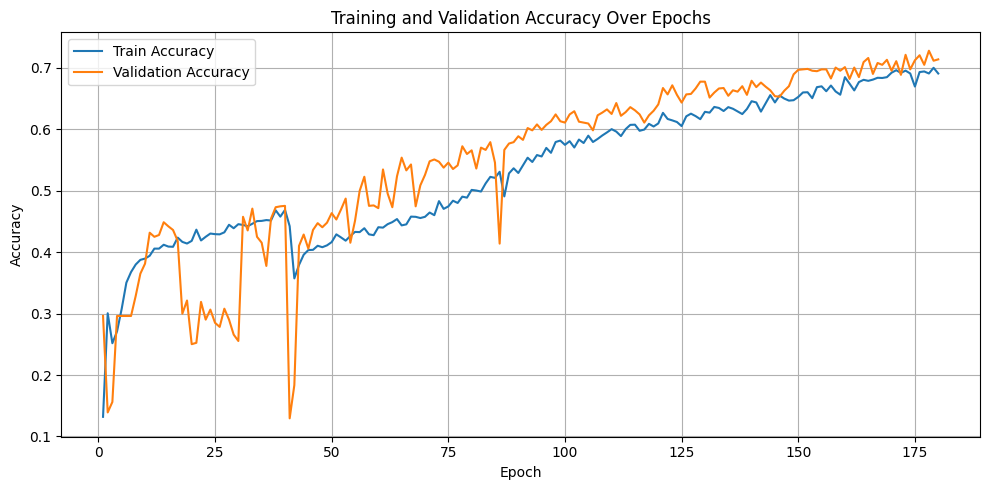

In [9]:

# -----------------------------
# 📊 PLOT ACCURACY OVER EPOCHS
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Found 1351 images belonging to 13 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 328s 8s/step - accuracy: 0.6711 - loss: 1.0284

🧪 Test Loss: 0.8812
🧪 Test Accuracy: 0.7135
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 600ms/step

📄 Classification Report:
                   precision    recall  f1-score   support

      Dam Failure       0.60      0.23      0.33        13
       Earthquake       0.72      0.67      0.69       185
  Emergency_alarm       0.70      0.78      0.74       124
        Explosion       0.70      0.09      0.16        78
            Flood       0.67      0.84      0.75        76
        Gun_Shots       0.42      0.71      0.53        35
          Tsunami       0.64      0.70      0.67        89
Volcanic Eruption       0.47      0.75      0.57       111
         Wildfire       0.98      0.99      0.99       400
              dog       0.53      0.30      0.39        56
   glass_breaking       0.61      0.85      0.71        60
     thunderstorm       0.44      0.34      0.39        58
             wind       0.47      0.21      0

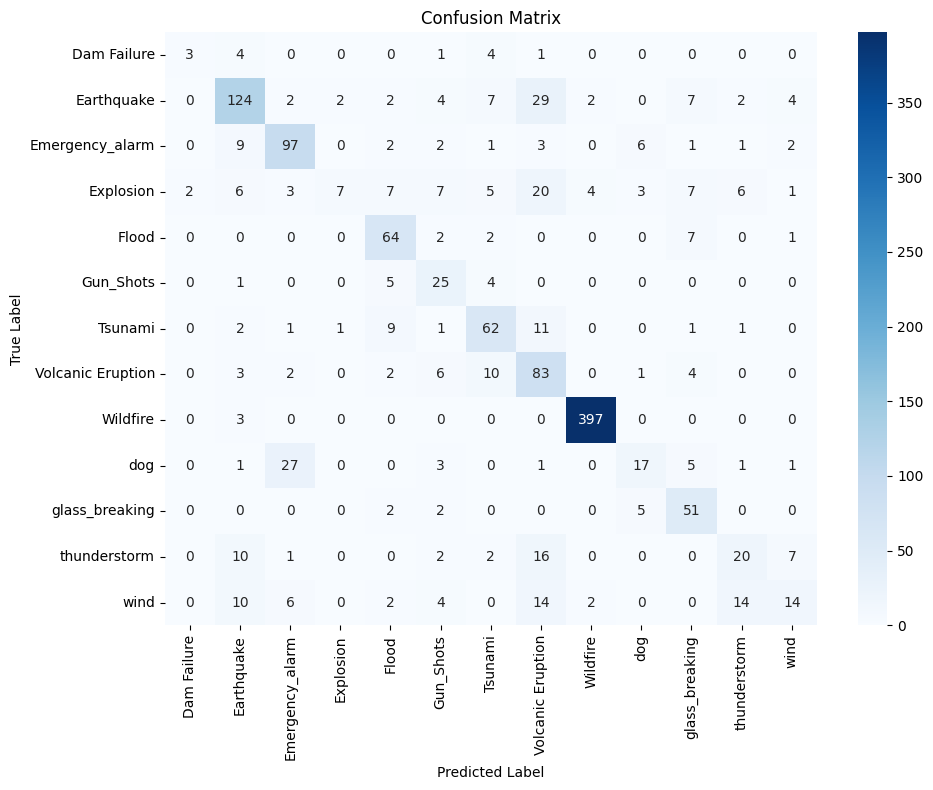

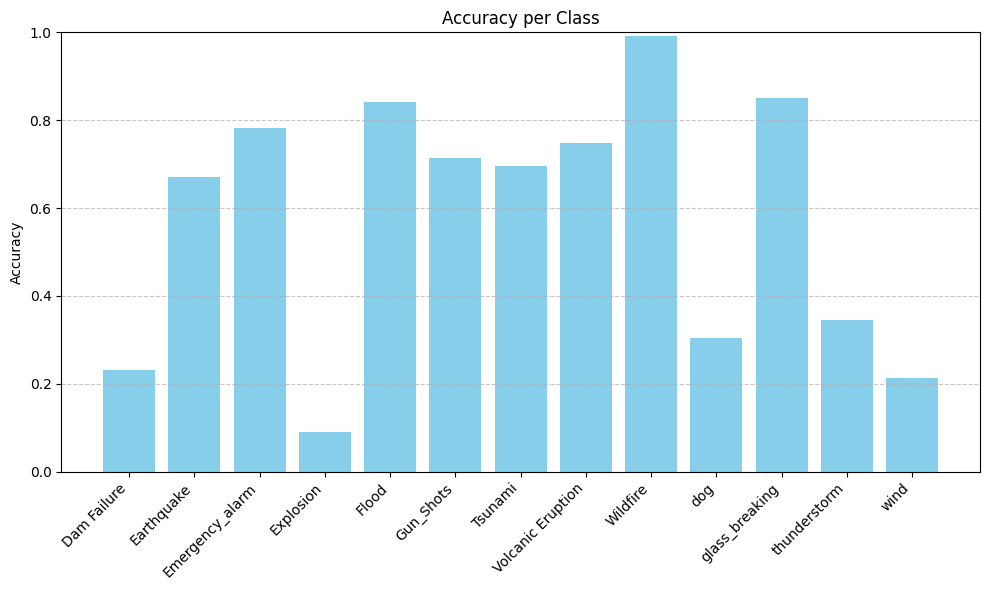

In [12]:
# -----------------------------
# 📉 EVALUATE MODEL
# -----------------------------
import tensorflow as tf # Import TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
import numpy as np # Import NumPy

model = tf.keras.models.load_model(model_path)

# -----------------------------
# Re-define test_generator
# -----------------------------
base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
image_dir = os.path.join(base_dir, 'STFT_Images_1_Sec')
test_dir = os.path.join(image_dir, 'Test/Sounds')
num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1  # seconds
channels = 3
batch_size = 32
epochs = 180

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)





# -----------------------------
# 📉 EVALUATE MODEL
# -----------------------------

loss, accuracy = model.evaluate(test_generator)
print(f"\n🧪 Test Loss: {loss:.4f}")
print(f"🧪 Test Accuracy: {accuracy:.4f}")

# -----------------------------
# 🔮 PREDICTIONS
# -----------------------------
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# -----------------------------
# 🧾 CLASSIFICATION REPORT
# -----------------------------
print("\n📄 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# -----------------------------
# 📌 PER-CLASS ACCURACY
# -----------------------------
class_accuracy = {}
for i, label in enumerate(class_labels):
    idxs = np.where(true_classes == i)[0]
    correct = np.sum(predicted_classes[idxs] == i)
    total = len(idxs)
    class_accuracy[label] = correct / total if total > 0 else 0.0

print("\n🎯 Accuracy per Class:")
for label in class_labels:
    print(f"{label}: {class_accuracy[label]:.4f}")

# -----------------------------
# 🔥 CONFUSION MATRIX HEATMAP
# -----------------------------
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# -----------------------------
# 📊 PER-CLASS ACCURACY BAR PLOT
# -----------------------------
plt.figure(figsize=(10, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
